Implementation of non-MLP projection classifier

In [1]:
%pip install umap
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.manifold import TSNE
import umap
from scipy.special import expit  # Sigmoid function

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Class implementing binary classification. Code commented and optimized using ChatGPT.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

class Binary_NonML_CPS_Classifier:
    """
    A binary classifier using a combination of:
    - projection onto a class-difference vector (vec_diff)
    - similarity to a class signature vector (signature)

    Automatically computes vec_diff using 8 few-shot samples from each class.

    Args:
        weights (tuple): Weights for combining dim_score and sim_score.
        few_shot_n (int): Number of few-shot samples to compute vec_diff.
    """

    def __init__(self, few_shot_n=8):
        self.weights = [0.5, 0.5]
        self.few_shot_n = few_shot_n
        self.vec_diff = None
        self.signature = None
        self.threshold = 0.0
        self.X_mean = None
        self.X_std = None

    def _normalize(self, X):
        return (X - self.X_mean) / self.X_std
    
    def fit(self, X, y, steps=11, verbose=False):
        """
        Searches for the best (dim_score, sim_score) weighting based on training accuracy.

        Args:
            X (np.ndarray): Training feature matrix.
            y (np.ndarray): Binary labels (0 or 1).
            steps (int): Number of weight combinations to try (between 0 and 1).
            verbose (bool): If True, prints progress.

        Sets:
            self.weights: Best-performing weights.
            self.threshold: Threshold recomputed with best weights.
        """
        best_acc = 0.0
        best_weights = self.weights

        for w in np.linspace(0, 1, steps):
            self.weights = (w, 1 - w)
            self.train(X, y)
            preds = self.predict(X)
            acc = np.mean(preds == y)
            if verbose:
                print(f"Weights: ({w:.2f}, {1 - w:.2f}) | Accuracy: {acc:.2%}")
            if acc > best_acc:
                best_acc = acc
                best_weights = self.weights

        self.weights = best_weights
        self.train(X, y)  # retrain with best weights to set final threshold
        if verbose:
            print(f"\nBest Weights: {best_weights} | Best Accuracy: {best_acc:.2%}")

    def train(self, X, y):
        """
        Train the model using input features and binary labels (0 = neg, 1 = pos).

        Args:
            X (np.ndarray): Input embeddings.
            y (np.ndarray): Binary labels (0 or 1).
        """
        self.X_mean = X.mean(axis=0)
        self.X_std = X.std(axis=0)
        self.X_std[self.X_std == 0] = 1.0

        X_norm = self._normalize(X)

        pos_samples = X[y == 1][:self.few_shot_n]
        neg_samples = X[y == 0][:self.few_shot_n]

        # Compute and normalize vec_diff
        centroid_pos = pos_samples.mean(axis=0)
        centroid_neg = neg_samples.mean(axis=0)
        self.vec_diff = centroid_pos - centroid_neg
        self.vec_diff /= np.linalg.norm(self.vec_diff)
        # Compute and normalize class signature vector
        self.signature = X_norm[y == 1].mean(axis=0)
        self.signature /= np.linalg.norm(self.signature)

        # Compute combined scores
        dim_scores = X @ self.vec_diff
        dim_scores /= np.linalg.norm(dim_scores)

        sim_scores = X_norm @ self.signature
        sim_scores /= np.linalg.norm(sim_scores)

        combined_scores = self.weights[0] * dim_scores + self.weights[1] * sim_scores
        self.threshold = np.median(combined_scores)

    def predict_proba(self, X):
        """
        Predict probability scores for binary classification.

        Args:
            X (np.ndarray): Input features.

        Returns:
            np.ndarray: Probability estimates for classes [P(class=0), P(class=1)].
        """
        X_norm = self._normalize(X)

        dim_scores = X @ self.vec_diff
        dim_scores /= np.linalg.norm(dim_scores)

        sim_scores = X_norm @ self.signature
        sim_scores /= np.linalg.norm(sim_scores)

        combined_scores = self.weights[0] * dim_scores + self.weights[1] * sim_scores

        # Map to probability using sigmoid
        probs_pos = expit(combined_scores - self.threshold)
        probs_neg = 1.0 - probs_pos

        return np.vstack([probs_neg, probs_pos]).T
    
    def predict(self, X):
        """
        Predict binary class labels (0 or 1).

        Args:
            X (np.ndarray): Input embeddings.

        Returns:
            np.ndarray: Binary predictions.
        """
        X_norm = self._normalize(X)

        dim_scores = X @ self.vec_diff
        dim_scores /= np.linalg.norm(dim_scores)

        sim_scores = X_norm @ self.signature
        sim_scores /= np.linalg.norm(sim_scores)

        combined_scores = self.weights[0] * dim_scores + self.weights[1] * sim_scores
        return (combined_scores > self.threshold).astype(int)

    def score(self, X, y):
        """
        Compute classification accuracy.

        Args:
            X (np.ndarray): Input features.
            y (np.ndarray): Ground truth binary labels.

        Returns:
            float: Accuracy (proportion correct).
        """
        preds = self.predict(X)
        return np.mean(preds == y)
    def plot_binary_scores(model, X, y_true, indices, class_names=("Class 0", "Class 1"), figsize=(6, 3)):
        """
        Plot binary classifier score as heatmap for selected samples.
        
        Args:
            model (NonML_CPS_Classifier): Trained binary classifier.
            X (np.ndarray): Input features.
            y_true (np.ndarray): True binary labels (0 or 1).
            indices (list of int): Indices of samples to visualize.
            class_names (tuple): Names for class 0 and class 1.
            figsize (tuple): Size of the matplotlib figure.
        """
        y_pred = model.predict(X)

        # Compute combined scores
        X_norm = model._normalize(X)
        dim_scores = X @ model.vec_diff
        dim_scores /= np.linalg.norm(dim_scores)

        sim_scores = X_norm @ model.signature
        sim_scores /= np.linalg.norm(sim_scores)

        combined_scores = model.weights[0] * dim_scores + model.weights[1] * sim_scores

        # Scale scores to [0, 1] for visualization
        probs = (combined_scores - combined_scores.min()) / (combined_scores.max() - combined_scores.min())

        fig, axes = plt.subplots(len(indices), 1, figsize=figsize, sharex=True)

        if len(indices) == 1:
            axes = [axes]

        for ax, idx in zip(axes, indices):
            p0 = 1 - probs[idx]
            p1 = probs[idx]
            heat = np.array([[p0, p1]])

            sns.heatmap(
                heat,
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                cbar=False,
                xticklabels=class_names,
                yticklabels=["Prob"],
                ax=ax,
            )
            ax.tick_params(axis='x', rotation=45)
            correct = (y_pred[idx] == y_true[idx])
            color = "green" if correct else "red"
            ax.set_title(f"Idx {idx} — True: {class_names[y_true[idx]]} | Pred: {class_names[y_pred[idx]]}", color=color)

        plt.tight_layout()
        plt.show()


Creating wrapping for multi-class implementation using a OvO (One v. One) approach, with final model prediction aggregated using a majority voting system.

In [3]:
class NonML_CPS_Classifier:
    def __init__(self, few_shot_n=8):
        self.base_cls = Binary_NonML_CPS_Classifier
        self.models = []
        self.label_pairs = []
        self.le = LabelEncoder()
        self.class_labels = None
        self.few_shot_n = few_shot_n

    def fit(self, X, y, steps=11, verbose=False):
        y_encoded = self.le.fit_transform(y)
        self.class_labels = self.le.classes_
        self.models = []
        self.label_pairs = []

        for class_i, class_j in combinations(np.unique(y_encoded), 2):
            mask = (y_encoded == class_i) | (y_encoded == class_j)
            X_pair = X[mask]
            y_pair = y_encoded[mask]
            y_bin = (y_pair == class_j).astype(int)

            model = self.base_cls(few_shot_n=self.few_shot_n)
            model.fit(X_pair, y_bin, steps=steps, verbose=verbose)

            self.models.append(model)
            self.label_pairs.append((class_i, class_j))

    def predict_proba(self, X):
        """
        Predict class probabilities using normalized OvO vote counts.

        Args:
            X (np.ndarray): Input feature matrix.

        Returns:
            np.ndarray: Probability distribution over classes for each sample.
        """
        vote_counts = np.zeros((X.shape[0], len(self.class_labels)), dtype=int)

        for model, (i, j) in zip(self.models, self.label_pairs):
            preds = model.predict(X)
            for idx, pred in enumerate(preds):
                winner = j if pred == 1 else i
                vote_counts[idx, winner] += 1

        # Normalize to get probabilities
        probs = vote_counts / vote_counts.sum(axis=1, keepdims=True)
        return probs


    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.class_labels)), dtype=int)

        for model, (i, j) in zip(self.models, self.label_pairs):
            preds = model.predict(X)
            for idx, pred in enumerate(preds):
                winner = j if pred == 1 else i
                votes[idx, winner] += 1

        final_preds = np.argmax(votes, axis=1)
        return self.le.inverse_transform(final_preds)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def plot_multiclass_scores(self, X, y_true, indices=None, figsize=(8, 4)):
        """
        Plot OvO multiclass prediction votes for selected samples as heatmaps.

        Args:
            X (np.ndarray): Input features.
            y_true (np.ndarray): True class labels.
            indices (list or None): Indices of samples to plot (default: first 5).
            figsize (tuple): Figure size.
        """
        if indices is None:
            indices = list(range(min(5, len(X))))

        y_pred = self.predict(X)

        # Collect votes per sample
        votes = np.zeros((X.shape[0], len(self.class_labels)), dtype=int)
        for model, (i, j) in zip(self.models, self.label_pairs):
            preds = model.predict(X)
            for idx, pred in enumerate(preds):
                winner = j if pred == 1 else i
                votes[idx, winner] += 1

        fig, axes = plt.subplots(len(indices), 1, figsize=figsize, sharex=True)
        if len(indices) == 1:
            axes = [axes]

        for ax, idx in zip(axes, indices):
            vote_counts = votes[idx]
            total_votes = vote_counts.sum()
            probs = vote_counts / total_votes if total_votes > 0 else vote_counts

            sns.heatmap(
                probs.reshape(1, -1),
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                cbar=False,
                xticklabels=self.class_labels,
                yticklabels=["Vote Prob"],
                ax=ax,
                vmin=0,
                vmax=1,
            )
            correct = (y_pred[idx] == y_true[idx])
            color = "green" if correct else "red"
            ax.set_title(f"Idx {idx} — True: {y_true[idx]} | Pred: {y_pred[idx]}", color=color)
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

Test and example of binary model implementation.

Using embedding computed using the 'Voyager-3-large' model.

In [6]:
### BINARY IMPLEMENTATION

### Voyager Embeddings
label1 = 0; label2 = 1
labels = [label1, label2]
# Load and filter dataset
data_processed = pd.read_csv('processed_section_data.csv')
tokenized_data = pd.read_csv("processed_section_data_embedded.csv").to_numpy()
mask = data_processed['section_label'].isin(labels)
X_filtered = tokenized_data[mask]
y_filtered = data_processed[mask]['section_label'].to_numpy()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.30, random_state=2025
)

# Binarize labels: class "1" is the positive class
y_train_bin = (y_train == label2).astype(int)
y_test_bin = (y_test == label2).astype(int)


In [8]:
# Train and evaluate

model = Binary_NonML_CPS_Classifier()
model.fit(X_train, y_train_bin, steps = 11)
acc = model.score(X_test, y_test_bin)
print(f"Accuracy: {acc:.1%}")

Accuracy: 93.2%


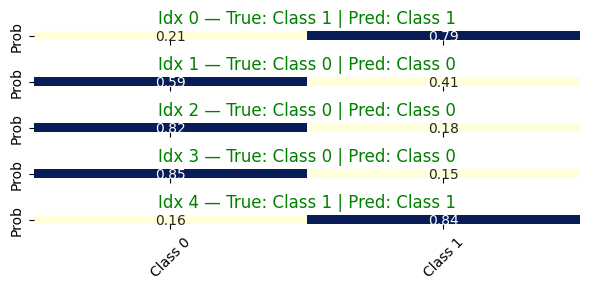

In [9]:
model.plot_binary_scores(X_test, y_test_bin, [0, 1, 2, 3, 4])

Using embeddings computed with OpenAI's 'text-embedding-3-large' model.

In [35]:
### ChatGPT Embeddings

seed = 2025

chatgpt_data = pd.read_csv("embeddingsChatGPT.csv")

# Convert string embeddings to lists of floats
embeddings = chatgpt_data['embedding'].apply(ast.literal_eval).to_list()

# Convert list of lists to numpy array
X = np.array(embeddings)
label1 = 0; label2 = 1
# Apply mask on X and y to filter out undesired labels
mask = chatgpt_data['section_label'].isin([label1,label2])
X = X[mask]
y = chatgpt_data.loc[mask, 'section_label'].to_numpy()

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=seed
)

In [36]:
# Binarize labels: class "1" is the positive class
y_train_bin = (y_train == label2).astype(int)
y_test_bin = (y_test == label2).astype(int)

# Train and evaluate
model = Binary_NonML_CPS_Classifier()
model.fit(X_train, y_train_bin, verbose=True)

acc = model.score(X_test, y_test_bin)
print(f"Accuracy: {acc:.1%}")

Weights: (0.00, 1.00) | Accuracy: 92.24%
Weights: (0.10, 0.90) | Accuracy: 92.24%
Weights: (0.20, 0.80) | Accuracy: 91.82%
Weights: (0.30, 0.70) | Accuracy: 91.40%
Weights: (0.40, 0.60) | Accuracy: 89.73%
Weights: (0.50, 0.50) | Accuracy: 88.89%
Weights: (0.60, 0.40) | Accuracy: 88.47%
Weights: (0.70, 0.30) | Accuracy: 87.63%
Weights: (0.80, 0.20) | Accuracy: 86.37%
Weights: (0.90, 0.10) | Accuracy: 85.95%
Weights: (1.00, 0.00) | Accuracy: 84.28%

Best Weights: (np.float64(0.0), np.float64(1.0)) | Best Accuracy: 92.24%
Accuracy: 94.6%


Testing binary performance on imbalanced data.

In [11]:
## TESTING ON IMBALANCED DATASET

import pandas as pd
seed = 2025
chatgpt_data = pd.read_csv("embeddingsChatGPT.csv")

# Convert string embeddings to lists of floats
embeddings = chatgpt_data['embedding'].apply(ast.literal_eval).to_list()

# Convert list of lists to numpy array
X = np.array(embeddings)
# Example: your labels
label1 = 0
label2 = 1

# Step 1: Get all samples of each label
df_label1 = chatgpt_data[chatgpt_data['section_label'] == label1]
df_label2 = chatgpt_data[chatgpt_data['section_label'] == label2]

# Step 2: Decide how many to sample
n_label2 = 1/10*len(df_label2)
n_label1 = len(df_label1)  # in case not enough samples

# Step 3: Randomly sample the required number of rows
sampled_label1 = df_label1.sample(n=int(n_label1), random_state=42)
sampled_label2 = df_label2.sample(n=int(n_label2), random_state=42)

# Step 4: Combine and get final mask
combined_indices = pd.concat([sampled_label1, sampled_label2]).index
mask = chatgpt_data.index.isin(combined_indices)

X = X[mask]
y = chatgpt_data.loc[mask, 'section_label'].to_numpy()

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=seed
)

# Binarize labels: class "1" is the positive class
y_train_bin = (y_train == label2).astype(int)
y_test_bin = (y_test == label2).astype(int)

# Train and evaluate
model = Binary_NonML_CPS_Classifier()
model.fit(X_train, y_train_bin, verbose = False)

acc = model.score(X_test, y_test_bin)
print(f"Accuracy: {acc:.1%}")

Accuracy: 61.9%


Full evaluation of binary model on OpenAI embeddings.

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import numpy as np
from itertools import combinations

all_labels = [0, 1, 2, 3, 4, 5]
metrics_list = []

for label1, label2 in combinations(all_labels, 2):
    # Convert list of lists to numpy array
    X = np.array(embeddings)
    # Apply mask on X and y to filter out undesired labels
    mask = chatgpt_data['section_label'].isin([label1,label2])
    X = X[mask]
    y = chatgpt_data.loc[mask, 'section_label'].to_numpy()

# Split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=seed
    )

    # Binarize: label2 is the positive class
    y_train_bin = (y_train == label2).astype(int)
    y_test_bin = (y_test == label2).astype(int)

    # Train and evaluate
    model = Binary_NonML_CPS_Classifier()
    model.fit(X_train, y_train_bin)

    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    acc = accuracy_score(y_test_bin, preds)
    prec = precision_score(y_test_bin, preds, zero_division=0)
    rec = recall_score(y_test_bin, preds, zero_division=0)
    f1 = f1_score(y_test_bin, preds, zero_division=0)

    metrics_list.append({
        "pair": f"{label1} vs {label2}",
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    })

# Convert to array for summary statistics
metrics_array = {key: np.array([m[key] for m in metrics_list]) for key in ["accuracy", "precision", "recall", "f1"]}

# Summary
summary = {
    "avg": {k: np.mean(v) for k, v in metrics_array.items()},
    "max": {k: np.max(v) for k, v in metrics_array.items()},
    "min": {k: np.min(v) for k, v in metrics_array.items()}
}

# Print results
print("=== Binary Class Pair Evaluation ===")
for m in metrics_list:
    print(f"{m['pair']}: Acc={m['accuracy']:.3f}, Prec={m['precision']:.3f}, Rec={m['recall']:.3f}, F1={m['f1']:.3f}")

print("\n=== Summary ===")
for stat, values in summary.items():
    print(f"\n{stat.upper()}:")
    for metric, value in values.items():
        print(f"{metric}: {value:.3f}")


=== Binary Class Pair Evaluation ===
0 vs 1: Acc=0.946, Prec=0.934, Rec=0.974, F1=0.954
0 vs 2: Acc=0.966, Prec=0.944, Rec=0.990, F1=0.967
0 vs 3: Acc=0.883, Prec=0.891, Rec=0.854, F1=0.872
0 vs 4: Acc=0.912, Prec=0.951, Rec=0.883, F1=0.916
0 vs 5: Acc=0.732, Prec=0.755, Rec=0.705, F1=0.729
1 vs 2: Acc=0.863, Prec=0.858, Rec=0.875, F1=0.867
1 vs 3: Acc=0.966, Prec=0.972, Rec=0.963, F1=0.967
1 vs 4: Acc=0.946, Prec=0.922, Rec=0.969, F1=0.945
1 vs 5: Acc=0.912, Prec=0.896, Rec=0.915, F1=0.905
2 vs 3: Acc=0.873, Prec=0.912, Rec=0.822, F1=0.865
2 vs 4: Acc=0.976, Prec=0.989, Rec=0.959, F1=0.974
2 vs 5: Acc=0.956, Prec=0.963, Rec=0.955, F1=0.959
3 vs 4: Acc=0.800, Prec=0.779, Rec=0.846, F1=0.811
3 vs 5: Acc=0.893, Prec=0.889, Rec=0.906, F1=0.897
4 vs 5: Acc=0.907, Prec=0.899, Rec=0.889, F1=0.894

=== Summary ===

AVG:
accuracy: 0.902
precision: 0.904
recall: 0.900
f1: 0.901

MAX:
accuracy: 0.976
precision: 0.989
recall: 0.990
f1: 0.974

MIN:
accuracy: 0.732
precision: 0.755
recall: 0.705
f1

Evaluation of full multi-class performance using Voyager embeddings.

In [48]:
### MULTI-CLASS IMPLEMENTATION

### Voyager Embeddings
# Load and filter dataset
data_processed = pd.read_csv('processed_section_data.csv')
tokenized_data = pd.read_csv("processed_section_data_embedded.csv").to_numpy()
X_filtered = tokenized_data
y_filtered = data_processed['section_label'].to_numpy()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.15, random_state=2025
)

In [49]:
# Train and evaluate
model = NonML_CPS_Classifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(f"Accuracy: {acc:.1%}")

Accuracy: 63.5%


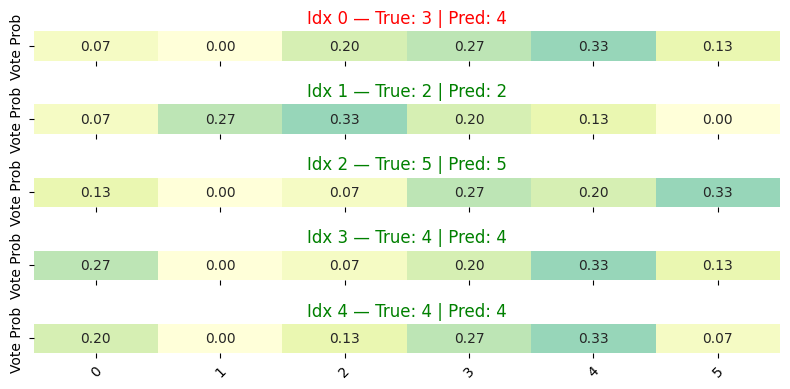

In [50]:
model.plot_multiclass_scores(X_test, y_test)

Evaluation of multi-class classification performance on OpenAI embeddings.

In [25]:
### ChatGPT Embeddings

seed = 2025

chatgpt_data = pd.read_csv("embeddingsChatGPT.csv")

# Convert string embeddings to lists of floats
embeddings = chatgpt_data['embedding'].apply(ast.literal_eval).to_list()

# Convert list of lists to numpy array
X = np.array(embeddings)

# Apply mask on X and y to filter out undesired labels
mask = chatgpt_data['section_label'].isin([0, 1, 2, 3, 4, 5])
X = X[mask]
y = chatgpt_data.loc[mask, 'section_label'].to_numpy()

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=seed
)

In [28]:
# Train and evaluate
model = NonML_CPS_Classifier()
model.fit(X_train, y_train)

acc = model.score(X_test, y_test)
print(f"Accuracy: {acc:.1%}")

### Model seems to perform better/worse on multi-class/binary classification tasks using ChatGPT-embeddings instead of Voyager-embeddings

Accuracy: 71.3%


In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss
import numpy as np

probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Basic metrics
acc = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

# Per-class breakdown
precision_c, recall_c, f1_c, support_c = precision_recall_fscore_support(
    y_test, y_pred, average=None, zero_division=0, labels=model.le.transform(model.class_labels)
)

# Confidence & Entropy
avg_confidence = np.mean(np.max(probs, axis=1))
entropy = -np.mean(np.sum(probs * np.log(probs + 1e-12), axis=1))

# Log Loss
try:
    ll = log_loss(model.le.transform(y_test), probs, labels=list(range(len(model.class_labels))))
except ValueError:
    ll = np.nan

# Print summary
print(f"Accuracy: {acc:.3f}")
print(f"Precision (weighted): {precision:.3f}")
print(f"Recall (weighted): {recall:.3f}")
print(f"F1 Score (weighted): {f1:.3f}")
print(f"Log Loss: {ll:.3f}")
print(f"Avg Confidence: {avg_confidence:.3f}")
print(f"Avg Entropy: {entropy:.3f}")

# Per-class metrics
for i, label in enumerate(model.class_labels):
    print(f"{label}: Precision={precision_c[i]:.3f}, Recall={recall_c[i]:.3f}, "
          f"F1={f1_c[i]:.3f}, Support={support_c[i]}")


Accuracy: 0.713
Precision (weighted): 0.715
Recall (weighted): 0.713
F1 Score (weighted): 0.713
Log Loss: 1.275
Avg Confidence: 0.331
Avg Entropy: 1.494
0: Precision=0.568, Recall=0.636, F1=0.600, Support=118
1: Precision=0.867, Recall=0.875, F1=0.871, Support=104
2: Precision=0.787, Recall=0.842, F1=0.813, Support=101
3: Precision=0.646, Recall=0.634, F1=0.640, Support=101
4: Precision=0.767, Recall=0.702, F1=0.733, Support=94
5: Precision=0.679, Recall=0.594, F1=0.633, Support=96


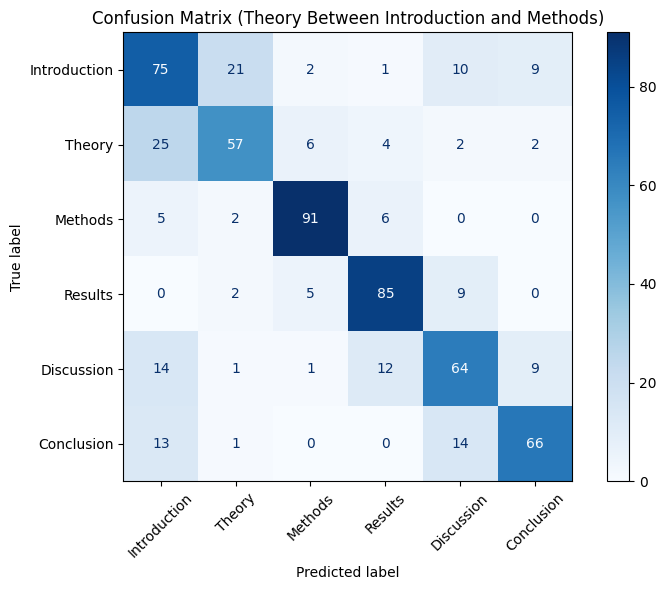

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define textual class labels (id-to-label mapping)
id2label = {
    0: 'Introduction',
    1: 'Methods',
    2: 'Results',
    3: 'Discussion',
    4: 'Conclusion',
    5: 'Theory'
}

# Define new custom label order (putting Theory between Introduction and Methods)
custom_order = [0, 5, 1, 2, 3, 4]
ordered_labels = [id2label[i] for i in custom_order]

# Get encoded string labels for test data if needed
# Assumes y_test and y_pred are in encoded integer format
y_test_named = [id2label[i] for i in y_test]
y_pred_named = [id2label[i] for i in y_pred]

# Compute confusion matrix with textual label order
cm = confusion_matrix(y_test_named, y_pred_named, labels=ordered_labels)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix (Theory Between Introduction and Methods)")
plt.tight_layout()
plt.show()
